## Reduced order model
Here we construct a simple reduced order model (ROM) for a scattering problem. The ROM is based on proper orthogonal decomposition (POD), which is similar to principle component analysis (PCA). 

We consider again the scattering of plane waves with different incident angles by a hexagon. We want to show that of the infinite number of possible incident angles, only a small finite number are required to create an accurate ROM. We can show this is the case by computing the solution for many incident angles and then taking the singular-value decomposition (SVD) of the matrix composed of those solutions vectors as its columns. In plotting the singular values we notice that they drop of in size, implying that an efficient ROM is possible.

The example used here is trivial but serves as a proof of concept. In a later demo we attempt to construct a ROM for this problem using an artificial neural network.

In [1]:
# Import packages
import os
import sys
# FIXME: avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from scipy.sparse.linalg import LinearOperator, gmres
import time
from vines.geometry.geometry import shape_2d, generatedomain2d
from vines.operators.acoustic_operators import get_operator_2d, circulant_embedding
from vines.fields.plane_wave import PlaneWave_2d
from vines.operators.acoustic_matvecs import mvp_2d
from vines.precondition.circulant_acoustic import mvp_circ_2d, circulant_preconditioner
import matplotlib.pyplot as plt

In [2]:
# Set problem parameters and discretization resolution
ko = 20          # wavenumber
refInd = 1.31     # refractive index
shape = 'hex'    # choose shape (hex, circle, ellipse)
radius = 1       # radius of shape
n_per_lam = 10   # number of points per wavelength
angle = 0  # Incident wave angle to x-axis
d_inc = np.array([np.cos(angle), np.sin(angle)])

In [3]:
lambda_ext = 2 * np.pi / ko  # wavelength
# Generate grid points (r), indices of interior points (idx), pixel size (dx), 
# shape vertices (verts), interior wavelength (lambda_int)

r, idx, dx, verts, lambda_int = shape_2d(shape, refInd, lambda_ext, radius, n_per_lam)

M, N, _ = r.shape  # number of voxels in x,y directions (M, N, respectively)

In [4]:
# Get Toeplitz operator
a = np.sqrt(dx**2 / np.pi)  # radius of equivalent area circle
toep = get_operator_2d(dx**2, ko, r, a)

In [5]:
# Circulant embedding of Toeplitz matrix (required for FFT matvec)
opCirc = circulant_embedding(toep, M ,N)

In [6]:
# Set up the mu^2-1 matrix, call it MR
mu_sq = np.ones((M, N))
mu_sq[idx] = refInd ** 2
MR = mu_sq - 1

In [7]:
# Define matrix-vector product and corresponding linear operator
mvp = lambda x: mvp_2d(x, opCirc, idx, MR)

A = LinearOperator((M*N, M*N), matvec=mvp)

In [8]:
# Construct circulant approximation of Toeplitz matrix in x-direction
start = time.time()
circ_inv = circulant_preconditioner(toep, M, N, refInd)
end = time.time()
print('Preconditioner assembly time = ', end - start)

Preconditioner assembly time =  0.04187512397766113


In [9]:
# Set up matrix-vector product with circulant preconditioner and establish preconditioner operator
mvp_prec = lambda x: mvp_circ_2d(x, circ_inv, M, N, idx)
prec = LinearOperator((M*N, M*N), matvec=mvp_prec)

In [10]:
# Assemble right-hand side (u_inc). Use a plane wave.
u_inc = PlaneWave_2d(1, ko, d_inc, r)

# Create an array that equals the incident field inside the scatterer and is zero outside
rhs = np.zeros((M, N), dtype=np.complex128)
rhs[idx] = u_inc[idx]
rhs_vec = rhs.reshape((M*N, 1), order='F')

In [11]:
# Perform iterative solve
it_count = 0

def iteration_counter(x):
    global it_count
    it_count += 1

start = time.time()
solp, info = gmres(A, rhs_vec, M=prec, tol=1e-5, callback=iteration_counter)
end = time.time()
print("The linear system was solved in {0} iterations".format(it_count))
print("Solve time {0} seconds".format(end-start))

The linear system was solved in 32 iterations
Solve time 0.18641304969787598 seconds


In [12]:
# Discretise (0, 60) degrees uniformly into n_angles angles
n_angles = 100
angles = np.linspace(0, 2*np.pi, n_angles + 1)

In [13]:
# FFP = np.zeros((n_angles, n), dtype=np.complex128)
sol_mat = np.zeros((M*N, n_angles), dtype=np.complex128)
for i_angle in range(n_angles):
    # Assemble right-hand side
    d_inc = np.array([np.cos(angles[i_angle]), np.sin(angles[i_angle])])
    u_inc = PlaneWave_2d(1, ko, d_inc, r)
    rhs = np.zeros((M, N), dtype=np.complex128)
    rhs[idx] = u_inc[idx]
    rhs_vec = rhs.reshape((M*N, 1), order='F')
    # Solve linear system
    it_count = 0
    start = time.time()
    solp, info = gmres(A, rhs_vec, M=prec, tol=1e-4, callback=iteration_counter)
    end = time.time()
    # print("The linear system was solved in {0} iterations".format(it_count))
    # print("Solve time {0} seconds".format(end-start))
    sol_mat[:, i_angle] = solp

In [14]:
# Take the SVD of the sol_matrix to see if a reduced order model could work
# Perform reduced SVD
u_, s_, vh_ = np.linalg.svd(sol_mat, full_matrices=False)

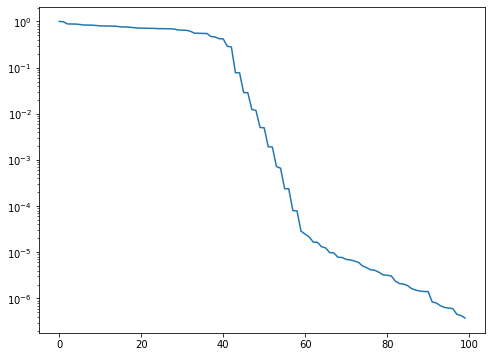

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.semilogy(s_/s_[0])
plt.show()

In [16]:
# Keep the first n_sing left-singular vectors
n_sing = 80
P = u_[:, 0:n_sing]
P.shape

(6132, 80)

In [17]:
# Create reduced matrix
R = np.matmul(np.conjugate(P).T, A(P))

In [18]:
# Now we have the ROM, let's select angles at random from the entire range [0, 2*\pi], rather than just [0, \pi/3] as before. And we compute the errors to see how accurate our ROM is.
n_angles = 10
angles = np.random.uniform(0, 2*np.pi, n_angles)

In [19]:
# Solve reduced system for each right-hand side and compute errors
errors = np.zeros(n_angles)
for i_angle in range(n_angles):
    # Assemble right-hand side
    d_inc = np.array([np.cos(angles[i_angle]), np.sin(angles[i_angle])])
    u_inc = PlaneWave_2d(1, ko, d_inc, r)
    rhs = np.zeros((M, N), dtype=np.complex128)
    rhs[idx] = u_inc[idx]
    rhs_vec = rhs.reshape((M*N, 1), order='F')
    # Solve linear system
    it_count = 0
    start = time.time()
    solp, info = gmres(A, rhs_vec, M=prec, tol=1e-4, callback=iteration_counter)
    end = time.time()
    # print("The linear system was solved in {0} iterations".format(it_count))
    # print("Solve time {0} seconds".format(end-start))
    # Solve ROM system
    # Project down the right-hand side vector
    rhs_ROM = np.matmul(np.conjugate(P).T, rhs_vec)
    # Solve ROM
    u_ROM = np.linalg.solve(R, rhs_ROM)
    u_R = np.matmul(P, u_ROM)
    sol_ROM = u_R[:,0]
    errors[i_angle] = np.linalg.norm(solp-sol_ROM) / np.linalg.norm(solp)

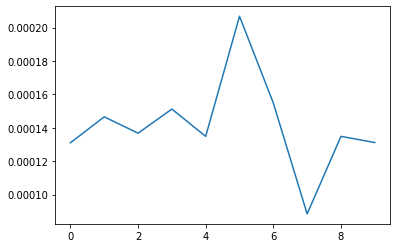

In [20]:
plt.plot(errors)

Now let's try this using an artificial neural network instead of POD.